In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import scipy
import matplotlib.pyplot as plt
import sklearn 
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sn
import warnings
import pickle
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('dataset.csv')
df.shape

(6019, 14)

In [3]:
df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


### **Data Cleaning:** ###

In [7]:
# droping unwanted columns
df.drop(['Unnamed: 0', 'Location', 'New_Price'], axis = 1, inplace = True)

In [8]:
# Converting error column
curr_time = datetime.datetime.now()
df['year'] = df['Year'].apply(lambda x : curr_time.year - x)

In [9]:
mileage_data = df["Mileage"].str.split(" ", expand = True)
df["Mileage"] = pd.to_numeric(mileage_data[0], errors = 'coerce')

In [10]:
Engine_data = df["Engine"].str.split(" ", expand = True)
df["Engine"] = pd.to_numeric(Engine_data[0], errors = 'coerce')

Power_data = df["Power"].str.split(" ", expand = True)
df["Power"] = pd.to_numeric(Power_data[0], errors = 'coerce')

In [11]:
df.isnull().sum()

Name                   0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage                2
Engine                36
Power                143
Seats                 42
Price                  0
year                   0
dtype: int64

In [12]:
df["Mileage"].fillna(df["Mileage"].astype("float64").mean(), inplace = True)

In [13]:
df["Engine"].fillna(df["Engine"].astype("float64").mean(), inplace = True)

df["Power"].fillna(df["Power"].astype("float64").mean(), inplace = True)

df["Seats"].fillna(df["Seats"].astype("float64").mean(), inplace = True)

In [14]:
df.dtypes

Name                  object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage              float64
Engine               float64
Power                float64
Seats                float64
Price                float64
year                   int64
dtype: object

In [15]:
df.columns

Index(['Name', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission',
       'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats', 'Price', 'year'],
      dtype='object')

There are 11 columns:

1. 'Name' : It gives us the brand of the car alongwith its model name.

2. 'Year' : It gives us the year of particular car model.

3. 'Kilometers_Driven' : It gives us the total distance in kms covered by car

4. 'Fuel_Type' :It gives us the type of fuel used by the car.

5. 'Transmission' : It tells us whether the gear transmission is Manual or Automatic

6. 'Owner_Type' : It tells us the total numbers of owners car had previously

7. 'Mileage' : It gives us the mileage of the car.

8. 'Engine' : It gives us the engine cc of the car.

9. 'Power' : It gives us the max_power of the car.

10. 'Seats' : It gives us the seats of the car.

11. 'Price': It gives us the price of the car.

Here 'Price' is our target variable.

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Year               6019 non-null   int64  
 2   Kilometers_Driven  6019 non-null   int64  
 3   Fuel_Type          6019 non-null   object 
 4   Transmission       6019 non-null   object 
 5   Owner_Type         6019 non-null   object 
 6   Mileage            6019 non-null   float64
 7   Engine             6019 non-null   float64
 8   Power              6019 non-null   float64
 9   Seats              6019 non-null   float64
 10  Price              6019 non-null   float64
 11  year               6019 non-null   int64  
dtypes: float64(5), int64(3), object(4)
memory usage: 564.4+ KB


In [76]:
df.describe()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,year
count,6019.000000,6.019000e+03,6019.000000,6019.000000,6019.000000,6019.000000,6019.000000,6019.000000
mean,2013.358199,5.873838e+04,18.134961,1621.276450,113.253050,5.278735,9.479468,8.641801
std,3.269742,9.126884e+04,4.581528,599.553865,53.231019,0.806012,11.187917,3.269742
min,1998.000000,1.710000e+02,0.000000,72.000000,34.200000,0.000000,0.440000,3.000000
25%,2011.000000,3.400000e+04,15.170000,1198.000000,78.000000,5.000000,3.500000,6.000000
50%,2014.000000,5.300000e+04,18.150000,1493.000000,98.600000,5.000000,5.640000,8.000000
75%,2016.000000,7.300000e+04,21.100000,1969.000000,138.030000,5.000000,9.950000,11.000000
max,2019.000000,6.500000e+06,33.540000,5998.000000,560.000000,10.000000,160.000000,24.000000


In [16]:
df['Name'].nunique()

1876

In [17]:
df.drop('Name', axis = 1, inplace = True)

In [18]:
print(df['Fuel_Type'].unique())
print(df['Transmission'].unique())
print(df['Owner_Type'].unique())

['CNG' 'Diesel' 'Petrol' 'LPG' 'Electric']
['Manual' 'Automatic']
['First' 'Second' 'Fourth & Above' 'Third']


In [19]:
df.head()

,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,year
0,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,1.75,12
1,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50,7
2,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50,11
3,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00,10
4,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74,9


### **Exploratory Data Analysis:** ###

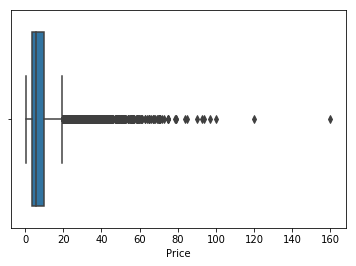

In [81]:
sn.boxplot(df['Price'])

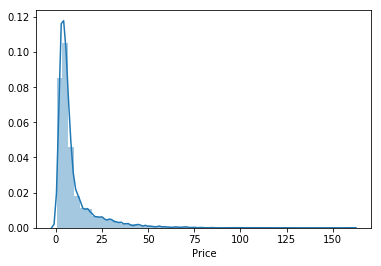

In [82]:
sn.distplot(df['Price'])

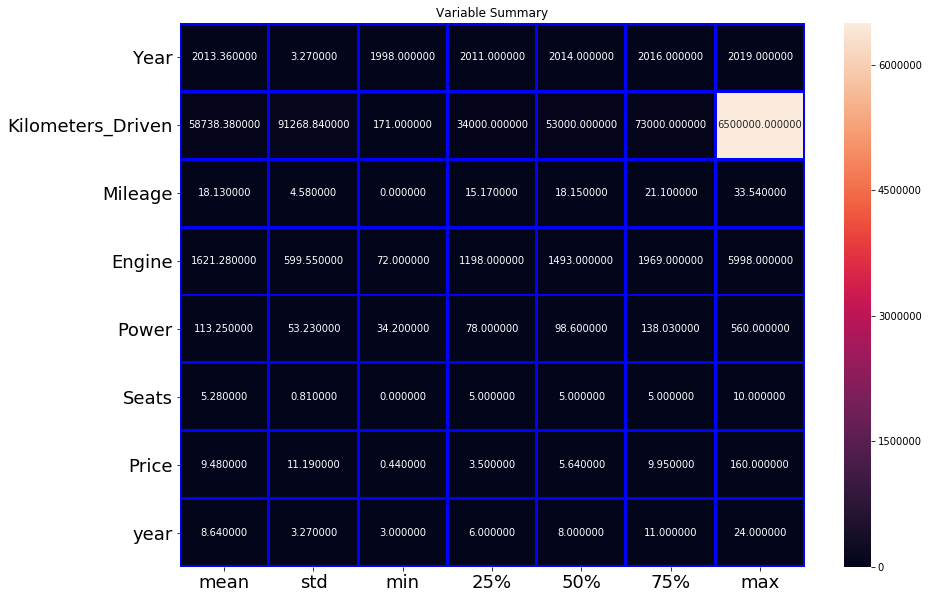

In [83]:
plt.figure(figsize=(14,10))
sn.heatmap(round(df.describe()[1:].transpose(),2),lw=2,linecolor='blue',annot=True,fmt='f',color='white')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Variable Summary')
plt.show()

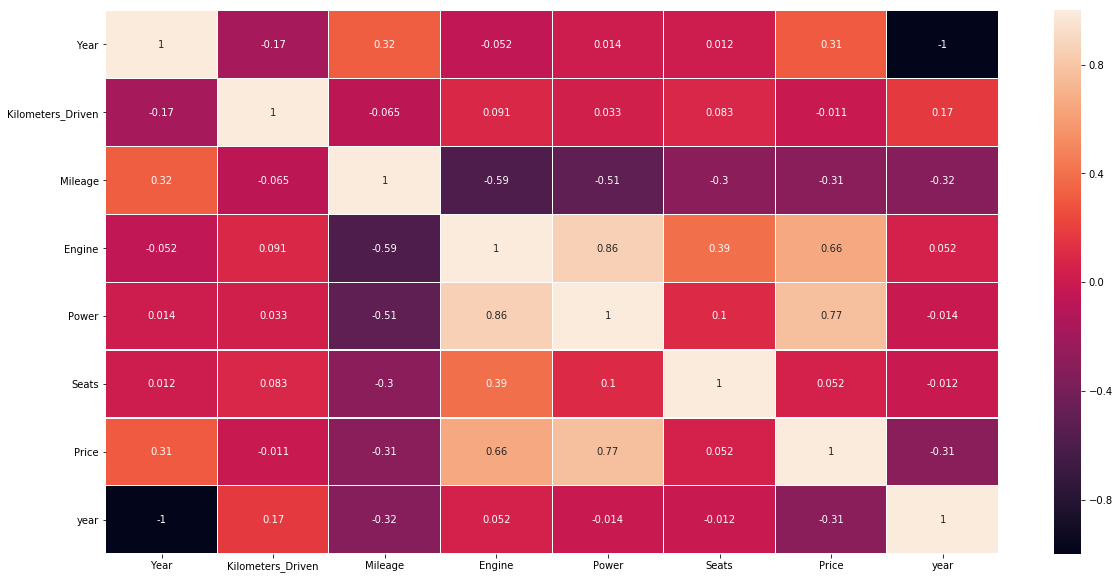

In [84]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), linewidth=0.1, annot = True)

In [26]:
X = df.drop(labels='Price', axis=1)
Y = df['Price']

In [28]:
X.head()

,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,year
0,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,12
1,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,7
2,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,11
3,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,10
4,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,9


In [35]:
X = pd.get_dummies(X, columns = ["Fuel_Type", "Transmission", "Owner_Type"], drop_first = True)

In [87]:
model = ExtraTreesRegressor()
model.fit(X,Y)

ExtraTreesRegressor()

In [88]:
print(model.feature_importances_)

[7.65172561e-02 3.23552476e-02 3.19165153e-02 1.18834278e-01
 2.63515245e-01 3.38608363e-02 9.42193994e-02 5.89578980e-02
 5.81180887e-05 9.12885216e-07 4.35578943e-03 2.79565004e-01
 1.11574385e-05 3.79319311e-03 2.03914887e-03]


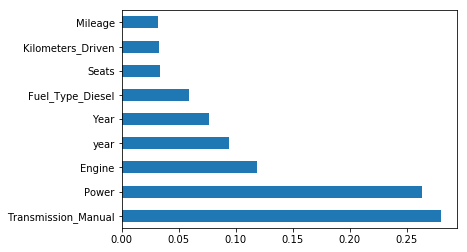

In [89]:
#plot graph of feature importances for visualization
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(9).plot(kind='barh')
plt.show()

### **Data Processing:** ###

In [22]:
for column in X.columns:
    std = StandardScaler()
    X[column] = std.fit_transform(X[column].values.reshape((-1,1)))

In [23]:
X.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,year,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Manual,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,-1.027139,0.145315,1.847799,-1.039653,-1.035066,-0.345849,1.027139,-1.067215,-0.018232,-0.040794,-0.915962,0.632529,-0.038698,-0.437773,-0.138322
1,0.502161,-0.194369,0.335077,-0.065515,0.243242,-0.345849,-0.502161,0.937018,-0.018232,-0.040794,-0.915962,0.632529,-0.038698,-0.437773,-0.138322
2,-0.721279,-0.139581,0.014197,-0.704376,-0.461293,-0.345849,0.721279,-1.067215,-0.018232,-0.040794,1.091749,0.632529,-0.038698,-0.437773,-0.138322
3,-0.415419,0.309678,0.575192,-0.622642,-0.460166,2.135710,0.415419,0.937018,-0.018232,-0.040794,-0.915962,0.632529,-0.038698,-0.437773,-0.138322
4,-0.109559,-0.197985,-0.640661,0.578351,0.517541,-0.345849,0.109559,0.937018,-0.018232,-0.040794,-0.915962,-1.580955,-0.038698,2.284289,-0.138322


In [24]:
# Function for computing metrics and showing results
def Computing_Metrics(y_true, y_pred):
    #1. MAE
    mae = mean_absolute_error(y_true, y_pred)
    #2. MSE
    mse = mean_squared_error(y_true, y_pred)
    #3. RMSE
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    #4. r2_score
    R2_score= r2_score(y_true,y_pred)
    
    dict_metrics = {'MAE' : [mae], 'MSE' : [mse], 'RMSE' : [rmse], 'R2_score' : [R2_score]}
    
    DF = pd.DataFrame(data=dict_metrics) 
    return  DF

In [39]:
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.3, random_state=25)

## **Machine Learning Model:** ##

### **1. Lasso Regression:** ###

In [94]:
#Parameters
parameters={'alpha':[1e-10,1e-6,1e-2,1,5,10,20,30,40]}

In [95]:
clf1=Lasso()
lasso=RandomizedSearchCV(clf1,parameters,scoring='neg_mean_squared_error',cv=5)
lasso.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, estimator=Lasso(),
                   param_distributions={'alpha': [1e-10, 1e-06, 0.01, 1, 5, 10,
                                                  20, 30, 40]},
                   scoring='neg_mean_squared_error')

In [96]:
print(lasso.best_params_)
print(lasso.best_score_)

{'alpha': 1}
-44.341097512141566


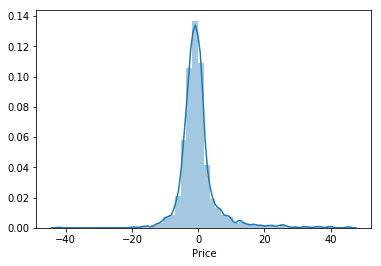

In [97]:
Y_lasso_pred=lasso.predict(X_test)
sns.distplot(Y_test-Y_lasso_pred)

**Observations:**

As we can see there is closely distributed gaussian distribution, so we can say that difference between predicted and real value is less.

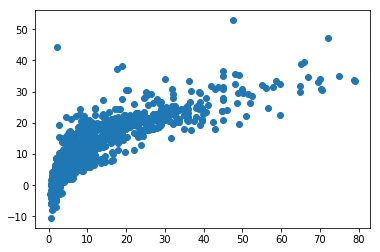

In [98]:
plt.scatter(Y_test,Y_lasso_pred)

**Observations:**

As we can see that predicted and real value mostly are inlined with few variation.

In [99]:
#accuracy metrics
Lasso= Computing_Metrics(Y_test, Y_lasso_pred)
Lasso

,MAE,MSE,RMSE,R2_score
0,3.563045,36.734165,6.060872,0.688292


### **2. KNeighborsRegressor:** ###

In [100]:
params={'leaf_size' : list(range(1,50)),
        'n_neighbors' : list(range(1,30)),
        'p': [1,2]}

In [101]:
clf_knn = KNeighborsRegressor()
Clf_knn = RandomizedSearchCV(clf_knn, params, n_iter=30, cv=5, verbose=1, random_state=42, n_jobs=-1)

In [102]:
Clf_knn.fit(X_train, Y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=KNeighborsRegressor(), n_iter=30, n_jobs=-1,
                   param_distributions={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29],
                                        'p': [1, 2]},
                   random_state=42, verbose=1)

In [103]:
Y_knn_pred = Clf_knn.predict(X_test)
Clf_knn.best_estimator_

KNeighborsRegressor(leaf_size=10, n_neighbors=6, p=1)

In [104]:
KNN= Computing_Metrics(Y_test, Y_knn_pred)
KNN

,MAE,MSE,RMSE,R2_score
0,1.843495,16.506021,4.06276,0.859938


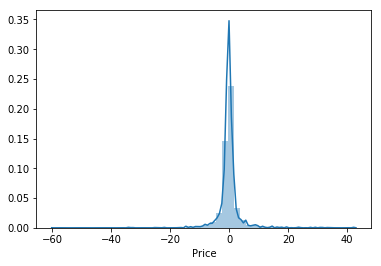

In [105]:
sns.distplot(Y_test-Y_knn_pred)

### **3. DecisionTreeRegressor:** ###

In [106]:
clf_dt = DecisionTreeRegressor()

criteria = ["mse", "friedman_mse", "mae", "poisson"]
splitter = ["best", "random"]
max_depth = list(np.arange(2,200,2))
min_samples_split = list(np.arange(1,100))
min_weight_fraction_leaf = list(np.linspace(0.0, 0.5))
max_features = ["auto", "sqrt", "log2"]
max_features.append(None)

params = {'criterion':criteria,
          'splitter':splitter,
          'max_depth':max_depth,
          'min_samples_split':min_samples_split,
          'min_weight_fraction_leaf':min_weight_fraction_leaf,
          'max_features':max_features
          }

Clf_dt = RandomizedSearchCV(clf_dt, params, n_iter=50, cv=5, verbose=1, random_state=42, n_jobs=-1)

Clf_dt.fit(X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'criterion': ['mse', 'friedman_mse',
                                                      'mae', 'poisson'],
                                        'max_depth': [2, 4, 6, 8, 10, 12, 14,
                                                      16, 18, 20, 22, 24, 26,
                                                      28, 30, 32, 34, 36, 38,
                                                      40, 42, 44, 46, 48, 50,
                                                      52, 54, 56, 58, 60, ...],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_split': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10, 11,
                                                     

In [108]:
Y_dt_pred = Clf_dt.predict(X_test)
Clf_dt.best_estimator_

DecisionTreeRegressor(criterion='friedman_mse', max_depth=166,
                      min_samples_split=70,
                      min_weight_fraction_leaf=0.061224489795918366)

In [109]:
DT= Computing_Metrics(Y_test, Y_dt_pred)
DT

,MAE,MSE,RMSE,R2_score
0,3.263759,41.900738,6.473078,0.644452


### **4. RandomForestRegressor:** ###

In [110]:
clf_rf = RandomForestRegressor()

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

Clf_rf = RandomizedSearchCV(clf_rf, params, n_iter=5, cv=5, verbose=1, random_state=42)

Clf_rf.fit(X_train, Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=1)

In [111]:
Y_rf_pred = Clf_rf.predict(X_test)
Clf_rf.best_estimator_

RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_split=5,
                      n_estimators=1400)

In [112]:
RF= Computing_Metrics(Y_test, Y_rf_pred)
RF

,MAE,MSE,RMSE,R2_score
0,1.631691,13.151167,3.626454,0.888406


### **5. XGBRegressor:** ###

In [113]:
clf_xgb = XGBRegressor(objective='reg:squarederror', tree_method='exact')

params = {'max_depth': [2, 4, 6],
              'gamma': [0, 0.2],
              'learning_rate': [0.01, 0.02, 0.3, 0.4], 
              'n_estimators': [100, 500], 
              'min_child_weight': [1, 4, 6],
              'subsample': [0.8], 
              'colsample_bytree': [0.8]
          }

Clf_xgb = RandomizedSearchCV(clf_xgb, params, n_iter=5, cv=5, verbose=1, random_state=42)

Clf_xgb.fit(X_train, Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          reg_alpha=None, reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                   

In [114]:
Y_xgb_pred = Clf_xgb.predict(X_test)
Clf_xgb.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0.2, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.02, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [115]:
XGB= Computing_Metrics(Y_test, Y_xgb_pred)
XGB

,MAE,MSE,RMSE,R2_score
0,1.779701,13.721725,3.704285,0.883564


### **6. GradientBoostingRegressor** ###

In [116]:
clf_gbr = GradientBoostingRegressor()
params = {
    "alpha":[0.01, 0.3, 0.5, 0.8, 1, 1.5],
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

Clf_gbr = RandomizedSearchCV(clf_gbr, params, n_iter=5, cv=5, verbose=1, random_state=42)

Clf_gbr.fit(X_train, Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=5,
                   param_distributions={'alpha': [0.01, 0.3, 0.5, 0.8, 1, 1.5],
                                        'learning_rate': [0.01, 0.1, 1, 10,
                                                          100],
                                        'max_depth': [1, 3, 5, 7, 9],
                                        'n_estimators': [5, 50, 250, 500]},
                   random_state=42, verbose=1)

In [117]:
Y_gbr_pred = Clf_gbr.predict(X_test)
Clf_gbr.best_estimator_

GradientBoostingRegressor(alpha=0.3, learning_rate=0.01, n_estimators=250)

In [118]:
GBR= Computing_Metrics(Y_test, Y_gbr_pred)
GBR

,MAE,MSE,RMSE,R2_score
0,2.424242,20.359819,4.512186,0.827237


### **Final Model:** ###

Randomforestregressor gives best accuracy among all other models. it has highest r2_score and lowest mae, mse, rmse. So we select RF as final model.

In [119]:
Model= RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_split=5, 
                             n_estimators=1400)
Model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_split=5,
                      n_estimators=1400)

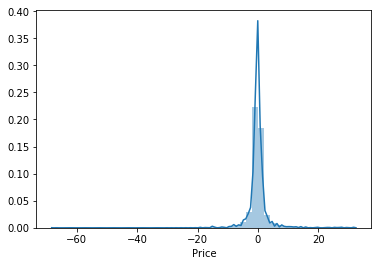

In [121]:
Y_rf_Pred = Model.predict(X_test)
sns.distplot(Y_test-Y_rf_Pred)

**Observations:**

As we can see there is closely distributed gaussian distribution, so we can say that difference between predicted and real value is less.

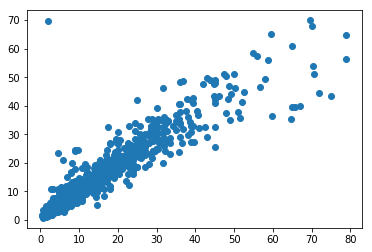

In [122]:
plt.scatter(Y_test,Y_rf_Pred)

**Observations:**

As we can see that predicted and real value mostly are inlined with few variation.

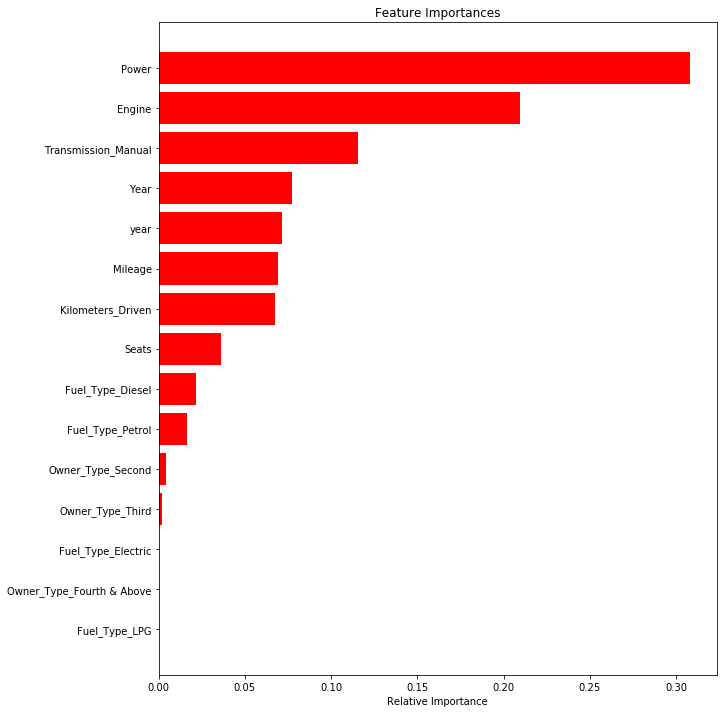

In [123]:
features = X_train.columns
importances = Model.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [62]:
import pickle
file = open('rf_model.pkl', 'wb')
pickle.dump(Model, file)

In [6]:
with open('rf_model.pkl', 'rb') as f:
    rf_m= pickle.load(f)

In [40]:
q= X_train.loc[[5]]

In [41]:
q

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,year,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Manual,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
5,2012,75000,21.1,814.0,55.2,5.0,10,0,0,1,0,1,0,0,0


In [31]:
Y[5]

2.35

In [42]:
rf_m.predict(q)

ValueError: X has 15 features, but RandomForestRegressor is expecting 14 features as input.